# Spam Filtering Techniques for Short Message Service
## EPFL - Adaptation and Learning (EE-621) 
## Adrien Besson and Dimitris Perdios

We assume that the reader has already gone through the python notebook `example_classifier.ipynb`.
As before, we focus on the logistic regression but the process can be applied to any other classifier.

From the results described in `example_classifier.ipynb`, we have an asymmetry in the values of the sensitivity and specificity.
This is due to the fact that we train the classifiers on a symmetric loss (misclassification error) or using a threshold of 0.5 for our Bayes estimator.

In this notebook, we explore two resampling methods that can be used to increase the sensitivity.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix
import sklearn.linear_model as lm
from sklearn.utils import resample, shuffle
import utils as ut
import matplotlib.pyplot as plt
import os

As usual, we first load and preprocess the data

In [2]:
# Load dataset
input_file = os.path.join(os.pardir, 'datasets', 'spam.csv')
data = pd.read_csv(input_file, encoding='latin_1', usecols=[0, 1])

# Rename the columns with more explicit names
data.rename(columns={'v1' : 'label', 'v2' : 'message'}, inplace=True)

# Convert labels into 0 and 1
data['class'] = data.label.map({'ham':0, 'spam':1})


We split the dataset into a training set and a test set using a 80/20 split

In [3]:
# Create a training set and a test set
train, test = train_test_split(data, train_size=0.8, test_size=0.2, random_state=10)

### 1. Downsampling of the majority class
We downsample the majority by randomly selecting some of the entries, in such a way that we have a perfectly balanced dataset.

In [4]:
# Number of spams and hams in the training set
n_hams, n_spams = train['class'].value_counts()

# Downsample the training set
train_ham = train.loc[train['label'] == 'ham']
train_spam = train.loc[train['label'] == 'spam']
train_ham_ds = train_ham.sample(n_spams, axis=0)
train_ds = pd.concat([train_ham_ds, train_spam])

# Reshuffle the new training set
train_ds = shuffle(train_ds)

# Create a CountVectorizer Object
vectorizer = CountVectorizer(encoding='latin-1', stop_words='english')

# Fit the vectorizer object
X_train = vectorizer.fit_transform(train_ds['message'])

# Transform the test set
X_test = vectorizer.transform(test['message'])

# Create a TfIdf Transformer object
transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Fit the model to the training set
features_train = transformer.fit_transform(X_train)

# Transform the test set
features_test = transformer.transform(X_test)

# Create labels
labels_train = train_ds['class']
labels_test = test['class']

We fit the regularized logistic regression classifier

In [5]:
# Create the logistic regression model
lrl2  = lm.LogisticRegression(penalty='l2', solver='liblinear', random_state=10)

# Create the 10-fold cross-validation model
gs_steps = 10
n_jobs = -1
cv=10
lr_param = {'C': np.logspace(-4, 9, gs_steps)}
lrl2_gscv = GridSearchCV(lrl2, lr_param, cv=10, n_jobs=n_jobs)

# Fit the cross-validation model
lrl2_gscv.fit(X=features_train, y=labels_train)
score_lrl2 = lrl2_gscv.score(X=features_test, y=labels_test)
print('Misclassification error: {0} %'.format((1-score_lrl2)*100))

Misclassification error: 2.8699551569506765 %


We also plot the confusion matrix to analyze the effect on the sensitivity

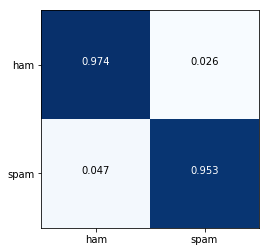

Sensitivity: 0.953 
Specificity: 0.974


In [6]:
# Compute the confusion matrix
preds_test = lrl2_gscv.best_estimator_.predict(features_test)
cm = confusion_matrix(y_true=labels_test, y_pred=preds_test)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix
classes = ['ham', 'spam']
digits = 3
ut.plot_confusion_matrix(cm, classes=classes, digits=digits)
plt.show()

# Show sensitivity and specificity
specificity = cm[0, 0] / np.sum(cm[0])
sensitivity = cm[1, 1] / np.sum(cm[1])
print('Sensitivity: {0:.3f} \nSpecificity: {1:.3f}'.format(sensitivity, specificity))

The value of the sensitivity has been significantly increased!
But the price to pay is a significantly lower specificity.

### 2. Upsampling the minority class

A more intelligent idea may consist in upsampling the minority class.
There exist many heuristicts to do to that.
We test a very simple one: we randomly (with replacement) select elements of the minority class that we duplicate until the two classes have the same number of elements.

In [7]:
# Upsample the minority class
train_ham = train.loc[train['label'] == 'ham']
train_spam = train.loc[train['label'] == 'spam']
train_spam_up = resample(train_spam, replace=True, n_samples=n_hams, random_state=10)
train_up = pd.concat([train_ham, train_spam_up])

# Reshuffle the new training set
train_up = shuffle(train_up)

# Create a CountVectorizer Object
vectorizer = CountVectorizer(encoding='latin-1', stop_words='english') 

# Fit the vectorizer object
X_train = vectorizer.fit_transform(train_up['message'])

# Transform the test set
X_test = vectorizer.transform(test['message'])

# Create a TfIdf Transformer object
transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Fit the model to the training set
features_train = transformer.fit_transform(X_train)

# Transform the test set
features_test = transformer.transform(X_test)

# Create labels
labels_train = train_up['class']
labels_test = test['class']

We again fit the regularized logistic regression on the augmented training set

In [8]:
# Create the logistic regression model
lrl2  = lm.LogisticRegression(penalty='l2', solver='liblinear', random_state=10)

# Create the 10-fold cross-validation model
gs_steps = 10
n_jobs = -1
cv=10
lr_param = {'C': np.logspace(-4, 9, gs_steps)}
lrl2_gscv = GridSearchCV(lrl2, lr_param, cv=10, n_jobs=n_jobs)

# Fit the cross-validation model
lrl2_gscv.fit(X=features_train, y=labels_train)
score_lrl2 = lrl2_gscv.score(X=features_test, y=labels_test)
print('Misclassification error: {0} %'.format((1-score_lrl2)*100))

Misclassification error: 1.255605381165914 %


We plot the associated confusion matrix

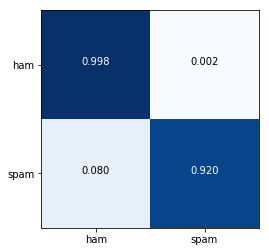

Sensitivity: 0.920 
Specificity: 0.998


In [9]:
# Compute the confusion matrix
preds_test = lrl2_gscv.best_estimator_.predict(features_test)
cm = confusion_matrix(y_true=labels_test, y_pred=preds_test)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix
classes = ['ham', 'spam']
digits = 3
ut.plot_confusion_matrix(cm, classes=classes, digits=digits)
plt.show()

# Show sensitivity and specificity
specificity = cm[0, 0] / np.sum(cm[0])
sensitivity = cm[1, 1] / np.sum(cm[1])
print('Sensitivity: {0:.3f} \nSpecificity: {1:.3f}'.format(sensitivity, specificity))

It can be seen that the sensitivity is slightly increased with the upsampling method. 